<a href="https://colab.research.google.com/github/imrealhelper/Linear-Algebra/blob/main/ase3001_exercises_soft_landing_success_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soft landing success predictor


<style>
.MathJax {
  font-family: "Common HTML";
}
</style>

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
\newcommand{\loss}{\ell}
\newcommand{\eloss}{\mc{L}}
\newcommand{\abs}[1]{| #1 |}
\newcommand{\norm}[1]{\| #1 \|}
\newcommand{\tp}{T}
$$

__<div style="text-align: right"> ASE3001: Computational Experiments for Aerospace Engineering, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_

<br>

___

<br>

## Launch log of reusable launchers

The goal here is to predict whether the Falcon 9 first stage will achieve a successful landing. SpaceX markets Falcon 9 rocket launches at a cost of 62 million USD, significantly lower than the 165 million USD or more charged by other providers. This cost advantage largely stems from SpaceX's ability to reuse the first stage of the rocket. By accurately predicting the likelihood of a successful first-stage landing, it becomes possible to estimate the overall cost of a launch. Such insights could be valuable for competing companies seeking to bid against SpaceX for rocket launch contracts.

<br>

The following cell will download launch data for SpaceX's Falcon 9, covering the period from 2010 to 2020.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_raw = pd.read_csv("https://jonghank.github.io/ase3001/files/falcon9_launch_data_raw.csv")
data_raw

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,2020-09-03,Falcon 9,15400.000000,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,2,B1060,-80.603956,28.608058,1
86,87,2020-10-06,Falcon 9,15400.000000,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,2,B1058,-80.603956,28.608058,1
87,88,2020-10-18,Falcon 9,15400.000000,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,5,B1051,-80.603956,28.608058,1
88,89,2020-10-24,Falcon 9,15400.000000,VLEO,CCAFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,2,B1060,-80.577366,28.561857,1


<br>

### Calculating the number of launches on each site:

In [2]:
data_raw['LaunchSite'].value_counts()


,count
LaunchSite,
CCAFS SLC 40,55
KSC LC 39A,22
VAFB SLC 4E,13


<br>

### Calculating the number and occurrence of each orbit:

Each launch aims to an dedicated orbit, and here are some common orbit types:

- LEO: Low Earth orbit (LEO)is an Earth-centred orbit with an altitude of 2,000 km (1,200 mi) or less (approximately one-third of the radius of Earth), or with at least 11.25 periods per day (an orbital period of 128 minutes or less) and an eccentricity less than 0.25. Most of the manmade objects in outer space are in LEO.

- VLEO: Very Low Earth Orbits (VLEO) can be defined as the orbits with a mean altitude below 450 km. Operating in these orbits can provide a number of benefits to Earth observation spacecraft as the spacecraft operates closer to the observation.

- GTO: A geosynchronous orbit is a high Earth orbit that allows satellites to match Earth's rotation. Located at 22,236 miles (35,786 kilometers) above Earth's equator, this position is a valuable spot for monitoring weather, communications and surveillance. Because the satellite orbits at the same speed that the Earth is turning, the satellite seems to stay in place over a single longitude, though it may drift north to south,” NASA wrote on its Earth Observatory website.

- SSO (or SO): It is a Sun-synchronous orbit also called a heliosynchronous orbit is a nearly polar orbit around a planet, in which the satellite passes over any given point of the planet's surface at the same local mean solar time.

- ES-L1: At the Lagrange points the gravitational forces of the two large bodies cancel out in such a way that a small object placed in orbit there is in equilibrium relative to the center of mass of the large bodies. L1 is one such point between the sun and the earth.

- HEO: A highly elliptical orbit, is an elliptic orbit with high eccentricity, usually referring to one around Earth.

- ISS: A modular space station (habitable artificial satellite) in low Earth orbit. It is a multinational collaborative project between five participating space agencies: NASA (United States), Roscosmos (Russia), JAXA (Japan), ESA (Europe), and CSA (Canada).

- MEO: Geocentric orbits ranging in altitude from 2,000 km (1,200 mi) to just below geosynchronous orbit at 35,786 kilometers (22,236 mi). Also known as an intermediate circular orbit. These are "most commonly at 20,200 kilometers (12,600 mi), or 20,650 kilometers (12,830 mi), with an orbital period of 12 hours.

- HEO: Geocentric orbits above the altitude of geosynchronous orbit (35,786 km or 22,236 mi).

- GEO: It is a circular geosynchronous orbit 35,786 kilometres (22,236 miles) above Earth's equator and following the direction of Earth's rotation.

- PO It is one type of satellites in which a satellite passes above or nearly above both poles of the body being orbited (usually a planet such as the Earth).

In [3]:
data_raw['Orbit'].value_counts()

,count
Orbit,
GTO,27
ISS,21
VLEO,14
PO,9
LEO,7
SSO,5
MEO,3
ES-L1,1
HEO,1


<br>

### Calculating the number and occurence of mission outcomes:

In the dataset, there are multiple scenarios where the booster failed to land successfully. These outcomes are categorized as follows:

-	True Ocean: Indicates the booster successfully landed in a designated region of the ocean.
-	False Ocean: Indicates the booster attempted to land in a designated region of the ocean but was unsuccessful.
-	True RTLS (Return to Launch Site): Indicates the booster successfully landed on a ground pad near the launch site.
-	False RTLS: Indicates the booster attempted to land on a ground pad near the launch site but was unsuccessful.
-	True ASDS (Autonomous Spaceport Drone Ship): Indicates the booster successfully landed on a drone ship at sea.
-	False ASDS: Indicates the booster attempted to land on a drone ship at sea but was unsuccessful.

These distinctions provide detailed insight into the landing outcomes and help analyze the performance of SpaceX's landing strategies.

In [4]:
landing_outcomes = data_raw['Outcome'].value_counts()
landing_outcomes

,count
Outcome,
True ASDS,41
None None,19
True RTLS,14
False ASDS,6
True Ocean,5
False Ocean,2
None ASDS,2
False RTLS,1


<br>

Among the landing outcomes listed, the following are considered successful soft landings:

-	True ASDS: A successful landing on an Autonomous Spaceport Drone Ship at sea.
-	True RTLS: A successful landing on a ground pad near the launch site.
-	True Ocean: A successful landing in a designated region of the ocean.

These outcomes indicate that the booster landed safely and could potentially be recovered or reused, contributing to the cost-efficiency of SpaceX's operations.

<br>

The final column, Class, serves as the classification variable that indicates the outcome of each launch. A value of 0 means the first stage did not land successfully, and a value of 1 means the first stage landed successfully.
This classification provides a binary outcome for evaluating and predicting the success of the first-stage landings.

<br>

### Visualizing relationship between payload and Flight Number:

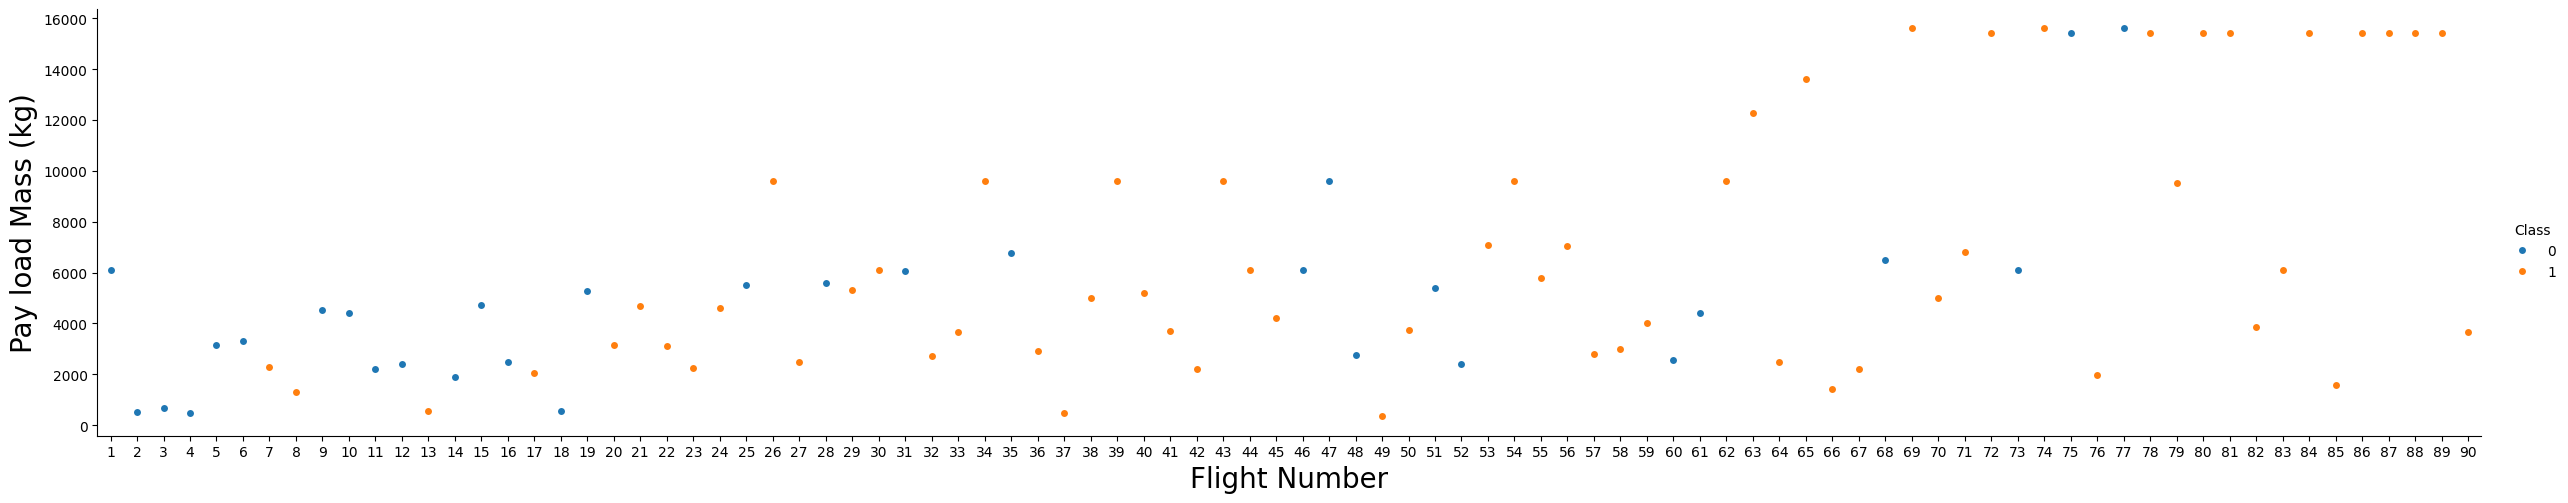

In [5]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", \
            data=data_raw, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

<br>

### Visualizing the relationship between Flight Number and Launch Site:

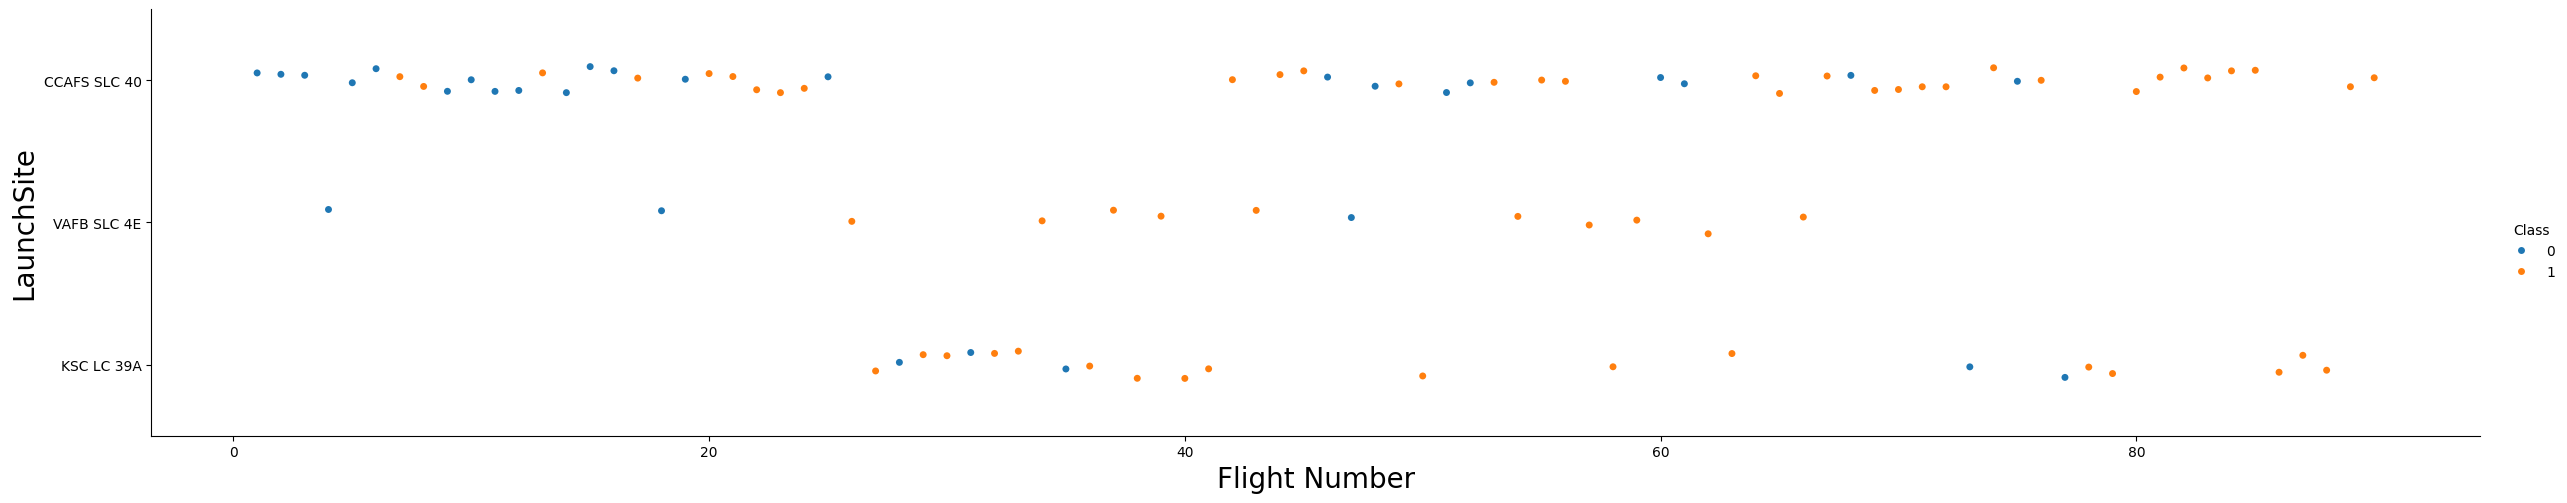

In [6]:
sns.catplot(y='LaunchSite', x='FlightNumber', hue='Class', \
            data=data_raw, aspect=5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

<br>

### Visualizing the relationship between Payload and Launch Site:

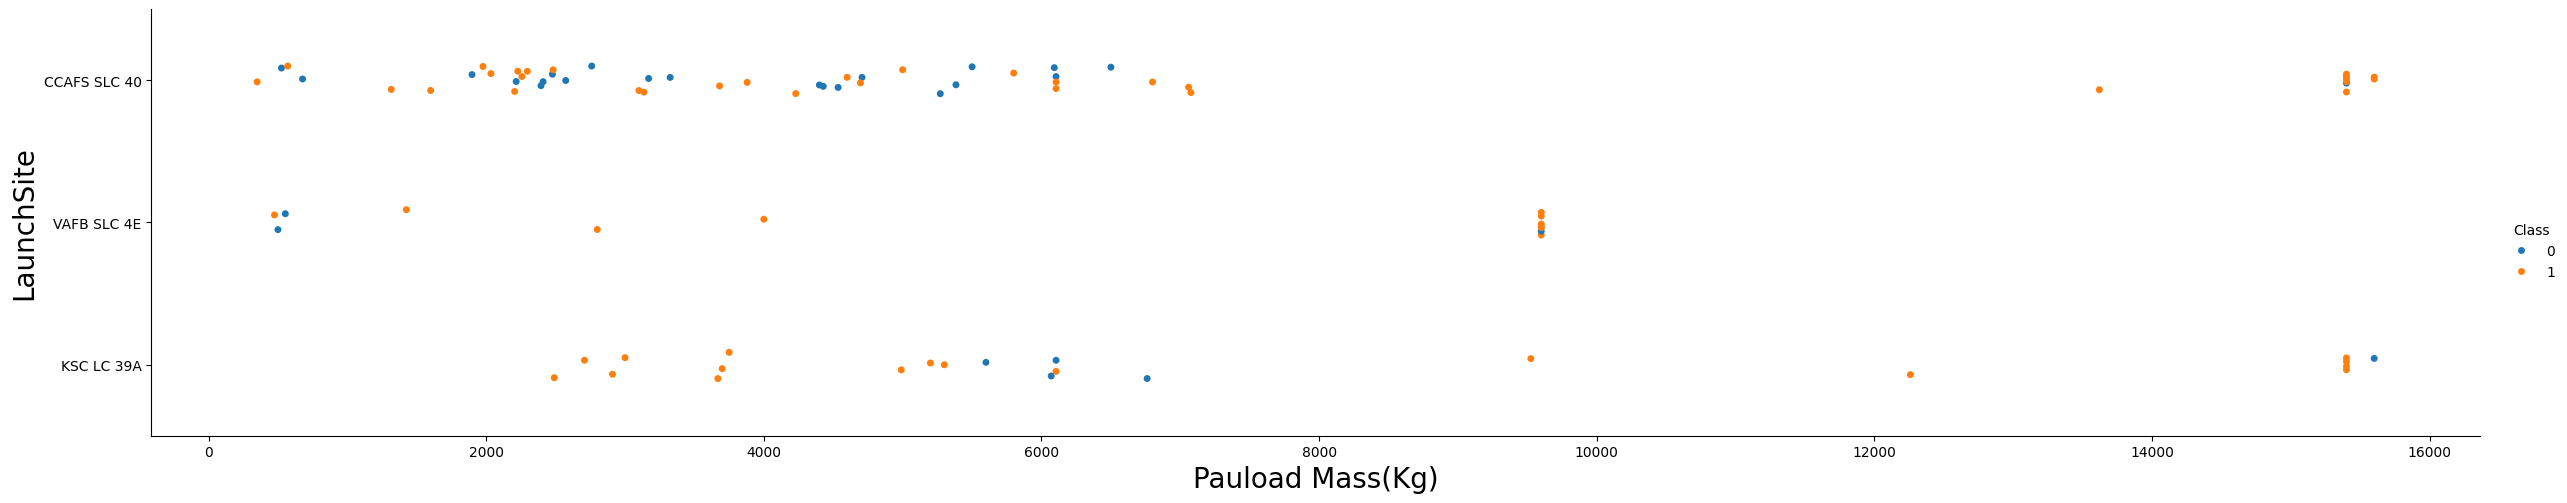

In [7]:
sns.catplot(y='LaunchSite', x='PayloadMass', hue='Class', \
            data=data_raw, aspect=5)
plt.xlabel("Pauload Mass(Kg)",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

<br>

### Visualizing the relationship between success rate of each Orbit type:


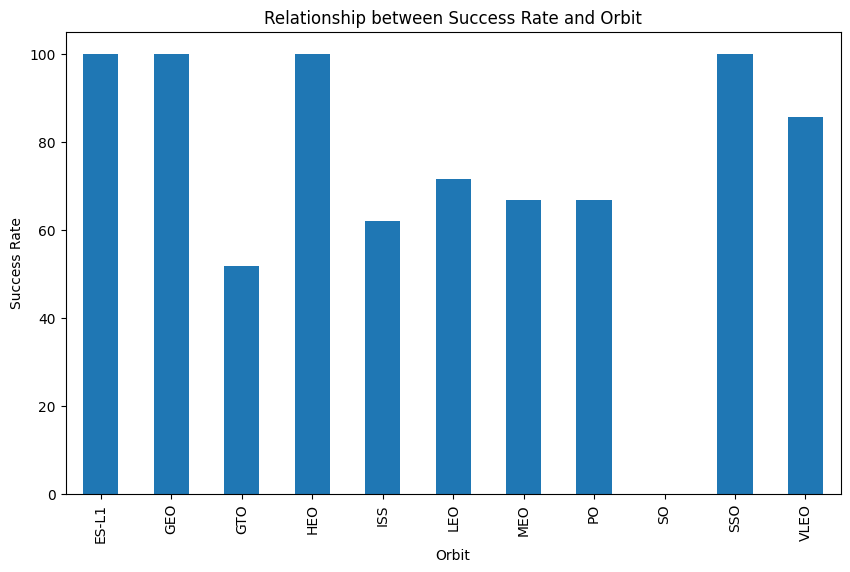

In [8]:
df_success=data_raw.groupby('Orbit')['Class'].mean()*100
df_success.plot(kind='bar', figsize=(10,6))
plt.xlabel('Orbit')
plt.ylabel('Success Rate')
plt.title('Relationship between Success Rate and Orbit')

plt.show()

<br>

### Visualizing the relationship between Flight Number and Orbit type:


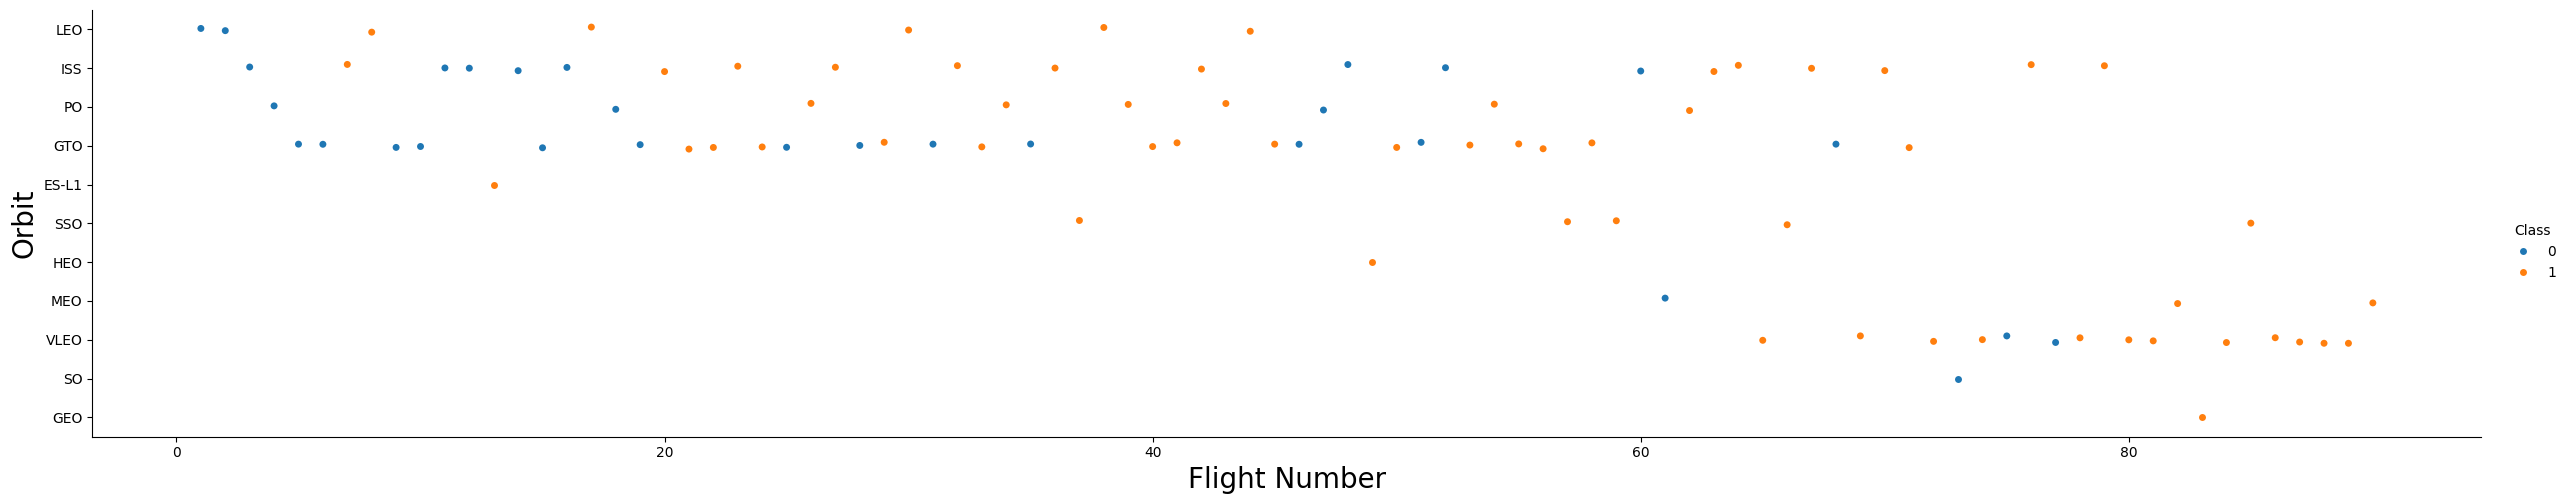

In [9]:
sns.catplot(y='Orbit', x='FlightNumber', hue='Class', \
            data=data_raw, aspect=5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

<br>

### Visualizing the relationship between Payload and Orbit type:


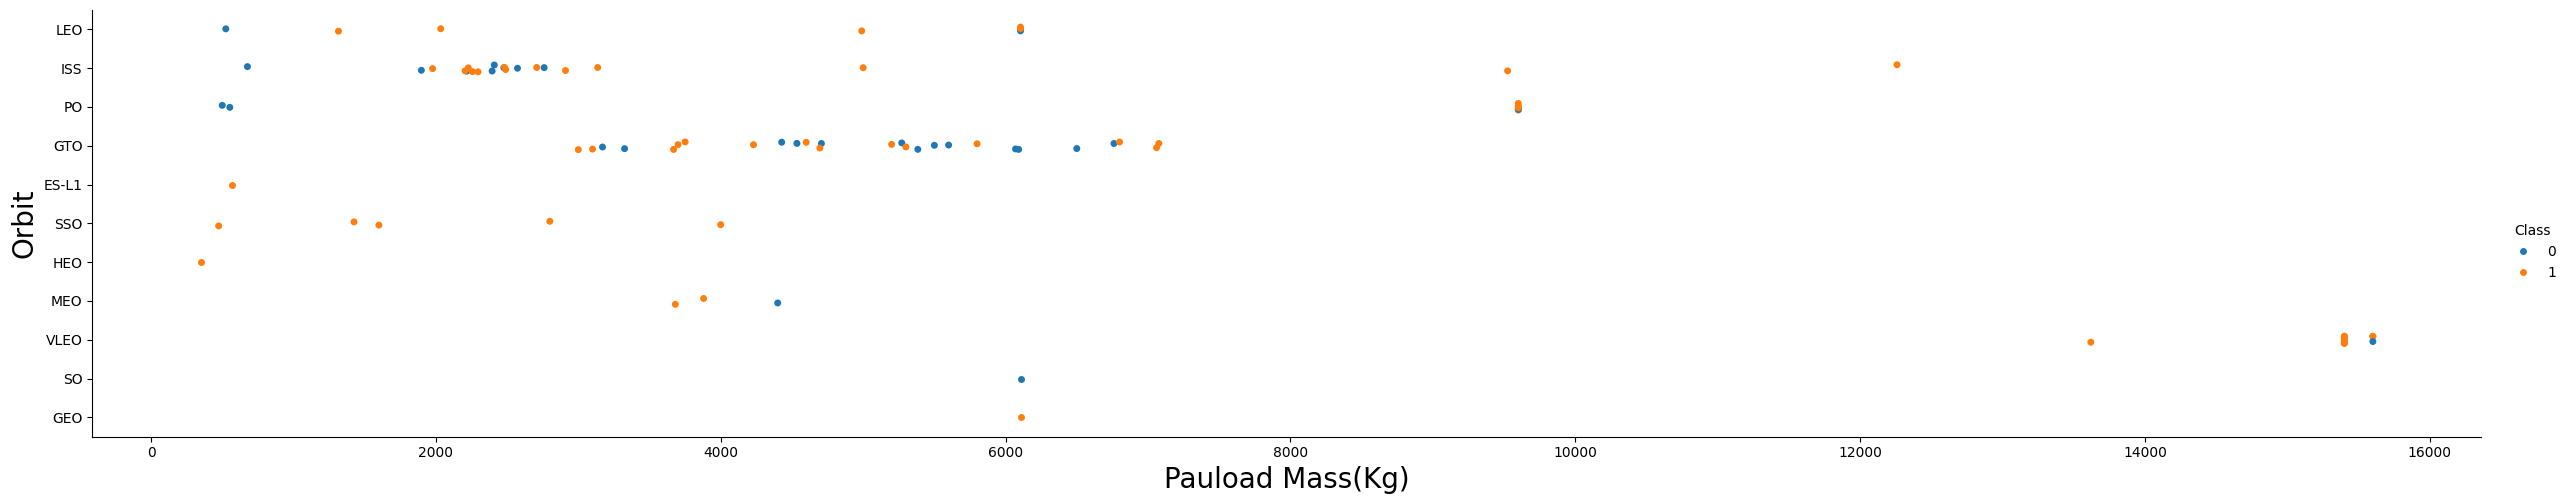

In [10]:
sns.catplot(y='Orbit', x='PayloadMass', hue='Class', \
            data=data_raw, aspect=5)
plt.xlabel("Pauload Mass(Kg)",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

<br>

### Visualizing launch success yearly trend:

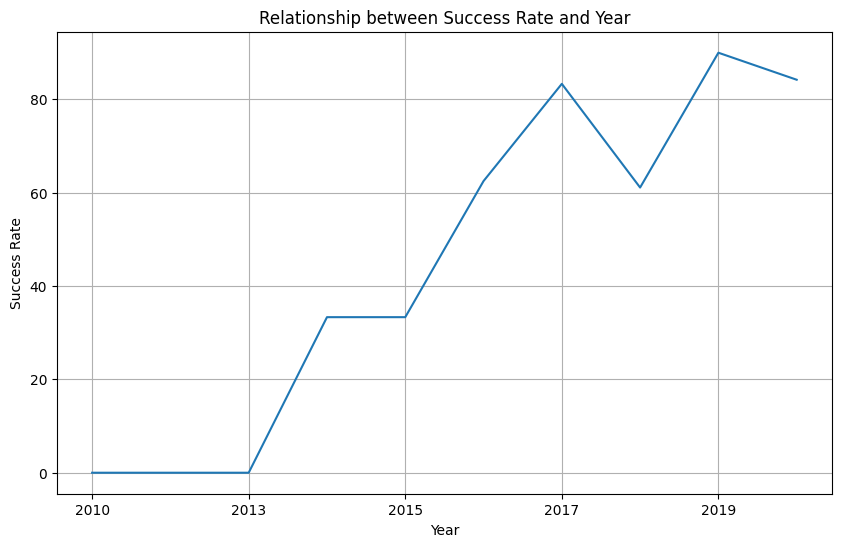

In [11]:
data_raw['Date'] = data_raw['Date'].astype(str)
year=[]

def Extract_year(df):
    for i in data_raw["Date"]:
        year.append(i.split("-")[0])
    return year

Extract_year(data_raw)
data_raw['Year']=year
fig,ax=plt.subplots()
df_success1=data_raw.groupby('Year')['Class'].mean()*100
df_success1.plot(kind='line', figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Success Rate')
plt.title('Relationship between Success Rate and Year')
plt.grid()
plt.show()

<br>

___

<br>

## Feature engineering

<br>

We selected the following features from the dataset to be used for predicting the success of the launch:

-	`FlightNumber`: A unique identifier for each launch.
-	`PayloadMass`: The mass of the payload (in kilograms) being carried by the rocket.
-	`Orbit`: The target orbit for the payload, useful for understanding mission objectives.
-	`LaunchSite`: The location from which the rocket was launched.
-	`Flights`: The total number of flights completed by the rocket booster.
-	`GridFins`: Whether grid fins were used during the flight (aerodynamic surfaces for control).
-	`Reused`: Whether the rocket booster had been reused in a prior mission.
- `Legs`: Whether the rocket was equipped with landing legs for recovery.
- `LandingPad`: The designated landing site for the booster.
-	`Block`: The version of the Falcon 9 rocket used for the launch.
-	`ReusedCount`: The number of times the booster has been reused.
- `Serial`: The unique serial number of the rocket booster.

These features encompass both numerical and categorical data, providing a comprehensive input set for predicting the success of Falcon 9 first-stage landings.

In [12]:
features = data_raw[['FlightNumber', 'PayloadMass', 'Orbit', \
                     'LaunchSite', 'Flights', 'GridFins', \
                     'Reused', 'Legs', 'LandingPad', 'Block', \
                     'ReusedCount', 'Serial']]
features

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6104.959412,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B1004
...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,15400.000000,VLEO,KSC LC 39A,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,2,B1060
86,87,15400.000000,VLEO,KSC LC 39A,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,2,B1058
87,88,15400.000000,VLEO,KSC LC 39A,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,5,B1051
88,89,15400.000000,VLEO,CCAFS SLC 40,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,2,B1060


<br>

In addition, one-hot encoding was applied to transform the categorical features: `Orbits`, `LaunchSite`, `LandingPad`, and `Serial`. This encoding ensures that these features are represented as numerical embeddings suitable for machine learning models.

You can download the dataframe containing the engineered features using the cell provided below. This dataframe includes the original data along with the one-hot encoded representations of the specified categorical variables.

In [13]:
data = pd.read_csv("https://jonghank.github.io/ase3001/files/falcon9_dataset.csv")
data

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True,Landing_Successful
0,1,6104.959412,1,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
1,2,525.000000,1,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
2,3,677.000000,1,1,0,0,0,0,0,1,...,0,0,0,1,0,1,0,1,0,0
3,4,500.000000,1,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
4,5,3170.000000,1,1,0,0,0,1,0,0,...,0,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,15400.000000,2,5,2,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,1
86,87,15400.000000,3,5,2,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,1
87,88,15400.000000,6,5,5,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,1
88,89,15400.000000,3,5,2,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,1


In [14]:
X = data.iloc[:,:-1].to_numpy()
y = data.iloc[:,-1].to_numpy()*2 - 1

N = len(y)
rand_ind = list(range(N))
np.random.seed(3001)
np.random.shuffle(rand_ind)

N_train = int(N*0.8)
X_train = X[rand_ind[:N_train]]
y_train = y[rand_ind[:N_train]]
X_test = X[rand_ind[N_train:]]
y_test = y[rand_ind[N_train:]]

<br>

---

<br>

_**(Problem 1)**_ Develop a Support Vector Machine (SVM) classifier using the training dataset. Select an appropriate regularization parameter ($\lambda$) to balance the trade-off between margin maximization and misclassification, ensuring the model achieves an acceptable test error. Evaluate the model by reporting the confusion matrix and calculating the misclassification error.

0.8333333333333334


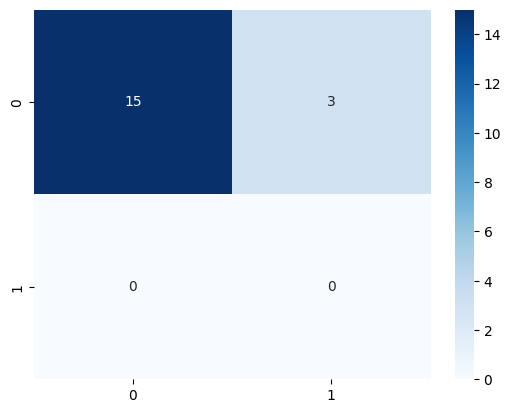

1.0


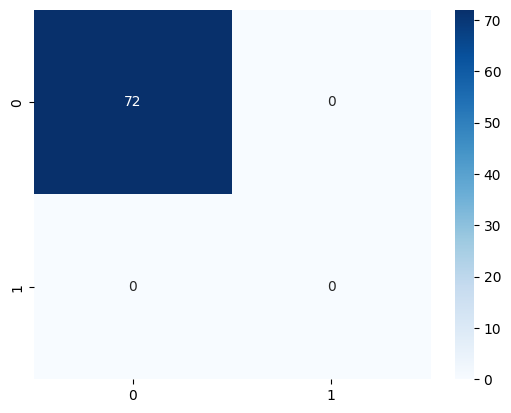

In [77]:

def solve_svm(X, y, lam=1):

  import cvxpy as cp

  w = cp.Variable(X.shape[1])
  b = cp.Variable()

  obj = cp.sum(cp.pos(1-cp.multiply(y,(X@w-b))))
  reg = cp.sum_squares(w)
  problem = cp.Problem(cp.Minimize(obj + lam*reg))
  problem.solve(solver=cp.CLARABEL)

  return w.value, b.value, obj.value, reg.value


def linear_kernel(X1, X2):
    return X1 @ X2.T


w_svm, b_svm, obj, reg = solve_svm(X_train, y_train, 0.1)

def svd(y):
  if y > 0:
    return 1
  else:
    return -1


def calculate_conf(X,y,w_svm,b_svm):
  confusion = np.zeros([2,2])
  for i in range(len(X)):
    y_valid = svd(X[i]@w_svm- b_svm)
    if y_valid != y[i]:
      if y_valid:
        confusion[0,1] +=1
      else:
        confusion[1,0] += 1
    else:
      if y_valid:
        confusion[0,0] +=1
      else:
        confusion[1,1] +=1
  return confusion

conf_test = calculate_conf(X_test,y_test,w_svm,b_svm)
print((conf_test[0,0]+conf_test[1,1])/(len(y_test)))
sns.heatmap(conf_test, annot=True, cmap='Blues')
plt.show()
conf_train = calculate_conf(X_train,y_train,w_svm,b_svm)
print((conf_train[0,0]+conf_train[1,1])/(len(y_train)))
sns.heatmap(conf_train, annot=True, cmap='Blues')
plt.show()

In [16]:
# your code here


<br>

---

<br>

_**(Problem 2)**_ Develop a Logistic Regression classifier using the training dataset. Select an appropriate regularization parameter ($\lambda$) to balance sensitivity and misclassification, ensuring the model achieves an acceptable test error. Evaluate the model by reporting the confusion matrix and calculating the misclassification error.

/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0.8888888888888888


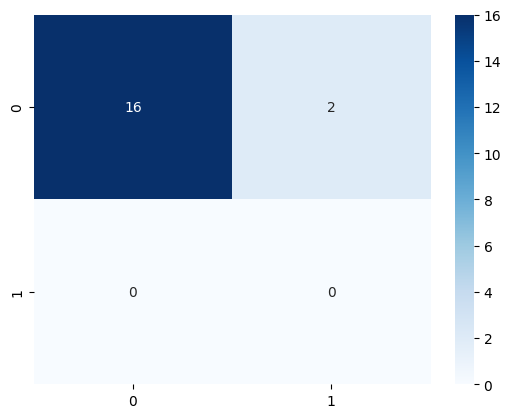

0.8333333333333334


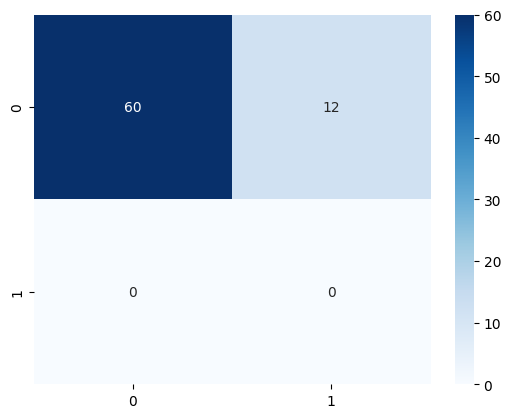

In [81]:
def solve_logistic_regression(X, y, lam=1):

  import cvxpy as cp

  w = cp.Variable(X.shape[1])
  b = cp.Variable()

  obj = cp.sum(cp.logistic(-cp.multiply(y,(X@w-b))))
  reg = cp.sum_squares(w)
  problem = cp.Problem(cp.Minimize(obj + lam*reg))
  problem.solve(solver=cp.CLARABEL)

  return w.value, b.value, obj.value, reg.value

w_svm, b_svm, obj, reg = solve_logistic_regression(X_train, y_train, 5)


def svd(y):
  if y > 0:
    return 1
  else:
    return -1


def calculate_conf(X,y,w_svm,b_svm):
  confusion = np.zeros([2,2])
  for i in range(len(X)):
    y_valid = svd(X[i]@w_svm- b_svm)
    if y_valid != y[i]:
      if y_valid:
        confusion[0,1] +=1
      else:
        confusion[1,0] += 1
    else:
      if y_valid:
        confusion[0,0] +=1
      else:
        confusion[1,1] +=1
  return confusion

conf_test = calculate_conf(X_test,y_test,w_svm,b_svm)
print((conf_test[0,0]+conf_test[1,1])/(len(y_test)))
sns.heatmap(conf_test, annot=True, cmap='Blues')
plt.show()
conf_train = calculate_conf(X_train,y_train,w_svm,b_svm)
print((conf_train[0,0]+conf_train[1,1])/(len(y_train)))
sns.heatmap(conf_train, annot=True, cmap='Blues')
plt.show()

In [18]:
# your code here
